In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Importing Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from sklearn.preprocessing import OneHotEncoder
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import torch.nn.functional as F
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading the dataset

In [ ]:
new_data=pd.read_csv('/content/drive/MyDrive/Tweets.csv')
new_data.info()
print(new_data.shape)
print(new_data['airline_sentiment'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

Visualization

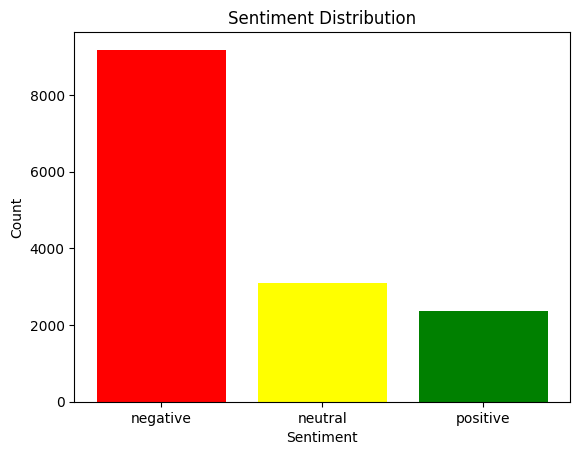

In [ ]:
sentiment_counts = new_data['airline_sentiment'].value_counts()

colors = {'negative': 'red', 'neutral': 'yellow', 'positive': 'green'}

plt.bar(sentiment_counts.index, sentiment_counts, color=[colors[s] for s in sentiment_counts.index])

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')


plt.show()

In [ ]:
new_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Choosing useful columns

In [ ]:
data=new_data[['text','airline_sentiment']]
DATA=pd.DataFrame(data)
print(DATA)
manq= DATA.isnull().sum()
print(manq)

                                                    text airline_sentiment
0                    @VirginAmerica What @dhepburn said.           neutral
1      @VirginAmerica plus you've added commercials t...          positive
2      @VirginAmerica I didn't today... Must mean I n...           neutral
3      @VirginAmerica it's really aggressive to blast...          negative
4      @VirginAmerica and it's a really big bad thing...          negative
...                                                  ...               ...
14635  @AmericanAir thank you we got on a different f...          positive
14636  @AmericanAir leaving over 20 minutes Late Flig...          negative
14637  @AmericanAir Please bring American Airlines to...           neutral
14638  @AmericanAir you have my money, you change my ...          negative
14639  @AmericanAir we have 8 ppl so we need 2 know h...           neutral

[14640 rows x 2 columns]
text                 0
airline_sentiment    0
dtype: int64


Data Preprocessing

In [ ]:
X=DATA[['text']]
y=DATA[['airline_sentiment']]
Y = pd.get_dummies(y)

Data Cleaning

In [ ]:
import re

def texte_propre(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()

    return text
texte = "🌟 Exciting News! Join us for the #DataInsights webinar on Aug 25th at 3 PM. Learn from industry experts about the latest data-driven strategies. Register now: webinar@example.com 📈🔍 #DataScience"
texte_nettoye = texte_propre(texte)
print(texte_nettoye)


 exciting news join us for the datainsights webinar on aug 25th at 3 pm learn from industry experts about the latest datadriven strategies register now webinarexamplecom  datascience


Tokenization

In [ ]:
from nltk.tokenize import RegexpTokenizer


def tokenisation(texte):
    tokeniser = RegexpTokenizer(r'\w+')
    tokens = tokeniser.tokenize(texte)
    return tokens
texte = "🌟 Exciting News! Join us for the #DataInsights webinar on Aug 25th at 3 PM. Learn from industry experts about the latest data-driven strategies. Register now: webinar@example.com 📈🔍 #DataScience"
TOKENS=tokenisation(texte)
print(TOKENS)

['Exciting', 'News', 'Join', 'us', 'for', 'the', 'DataInsights', 'webinar', 'on', 'Aug', '25th', 'at', '3', 'PM', 'Learn', 'from', 'industry', 'experts', 'about', 'the', 'latest', 'data', 'driven', 'strategies', 'Register', 'now', 'webinar', 'example', 'com', 'DataScience']


stemmatization

In [ ]:
from nltk.stem import PorterStemmer
def stemmatisation(text):
    stemmer = PorterStemmer()
    words = tokenisation(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text
texte = "🌟 Exciting News! Join us for the #DataInsights webinar on Aug 25th at 3 PM. Learn from industry experts about the latest data-driven strategies. Register now: webinar@example.com 📈🔍 #DataScience"

stem = stemmatisation(texte)
print(stem)

excit new join us for the datainsight webinar on aug 25th at 3 pm learn from industri expert about the latest data driven strategi regist now webinar exampl com datasci


Stop words

In [ ]:
import nltk
from nltk.corpus import stopwords
def keys_stopwords(text, language='english'):
    stop_words = set(stopwords.words(language))
    words = tokenisation(text)
    keywords = [word for word in words if word.lower() not in stop_words]
    return keywords
texte = "🌟 Exciting News! Join us for the #DataInsights webinar on Aug 25th at 3 PM. Learn from industry experts about the latest data-driven strategies. Register now: webinar@example.com 📈🔍 #DataScience"
keywords = keys_stopwords(texte , language='french')
print(keywords)

['Exciting', 'News', 'Join', 'us', 'for', 'the', 'DataInsights', 'webinar', 'Aug', '25th', 'at', '3', 'PM', 'Learn', 'from', 'industry', 'experts', 'about', 'the', 'latest', 'data', 'driven', 'strategies', 'Register', 'now', 'webinar', 'example', 'com', 'DataScience']


Text Preprocessing Function

In [ ]:
def pretraitement(text):
    phrase=texte_propre(text)
    phrase=keys_stopwords(phrase)
    phrase=str(phrase)
    phrase=stemmatisation(phrase)

    return phrase
texte = "🌟 Exciting News! Join us for the #DataInsights webinar on Aug 25th at 3 PM. Learn from industry experts about the latest data-driven strategies. Register now: webinar@example.com 📈🔍 #DataScience"
pretraitement(texte )

'excit news join us datainsight webinar aug 25th 3 pm learn industri expert latest datadriven strategi regist webinarexamplecom datasci'

TF-IDF « Term Frequency – Inverse Document Frequency >>

TF Term Frequency:
It measures the frequency of words in a document. It is the ratio of the number of times the word appears in a document to the total number of words in that document.




In [ ]:
def Term_Frequency(text, word):
    words = text.split()
    Nb_occ = 0

    for w in words:
        if w == word:
            Nb_occ += 1

    total= len(words)
    TF = Nb_occ / total
    return TF
    texte = "🌟 Exciting News! Join us for the #DataInsights webinar on Aug 25th at 3 PM. Learn from industry experts about the latest data-driven strategies. Register now: webinar@example.com 📈🔍 #DataScience"
mots = texte.split()

index = []
value = []

for mot in mots:
    TF = Term_Frequency(texte, mot)
    index.append(mot)
    value.append(TF)
for i in range (len(index)):
      tf=[index[i],value[i]]
      tf=np.array(tf)
      print(tf)


['🌟' '0.034482758620689655']
['Exciting' '0.034482758620689655']
['News!' '0.034482758620689655']
['Join' '0.034482758620689655']
['us' '0.034482758620689655']
['for' '0.034482758620689655']
['the' '0.06896551724137931']
['#DataInsights' '0.034482758620689655']
['webinar' '0.034482758620689655']
['on' '0.034482758620689655']
['Aug' '0.034482758620689655']
['25th' '0.034482758620689655']
['at' '0.034482758620689655']
['3' '0.034482758620689655']
['PM.' '0.034482758620689655']
['Learn' '0.034482758620689655']
['from' '0.034482758620689655']
['industry' '0.034482758620689655']
['experts' '0.034482758620689655']
['about' '0.034482758620689655']
['the' '0.06896551724137931']
['latest' '0.034482758620689655']
['data-driven' '0.034482758620689655']
['strategies.' '0.034482758620689655']
['Register' '0.034482758620689655']
['now:' '0.034482758620689655']
['webinar@example.com' '0.034482758620689655']
['📈🔍' '0.034482758620689655']
['#DataScience' '0.034482758620689655']


Applying the Preprocessing Function to Our Own Data

In [ ]:
X['text']=X['text'].apply(pretraitement)

X['text']

<ipython-input-47-f995ec84f749>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['text']=X['text'].apply(pretraitement)


0                              virginamerica dhepburn said
1          virginamerica plu youv ad commerci experi tacki
2        virginamerica didnt today must mean need take ...
3        virginamerica realli aggress blast obnoxi ente...
4                       virginamerica realli big bad thing
                               ...                        
14635          americanair thank got differ flight chicago
14636    americanair leav 20 minut late flight warn com...
14637    americanair pleas bring american airlin blackb...
14638    americanair money chang flight dont answer pho...
14639    americanair 8 ppl need 2 know mani seat next f...
Name: text, Length: 14640, dtype: object

Applying TF-IDF to Our Data (using Sklearn)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus=X['text'].to_list()
tfidf_vectorizer = TfidfVectorizer()
tfidf= tfidf_vectorizer.fit_transform(corpus)
print(tfidf.shape)

(14640, 12629)


Splitting the Dataset into Training and Testing Sets

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test= train_test_split(tfidf,Y,test_size = 0.3,random_state = 42) ## Let's take 70% of the data as training data.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10248, 12629)
(4392, 12629)
(10248, 3)
(4392, 3)


Converting the Data into Tensors

In [ ]:
X_train_tensor = torch.tensor(X_train.toarray(),dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values)
X_test_tensor = torch.tensor(X_test.toarray(),dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values)
print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([10248, 12629])
torch.Size([10248, 3])
torch.Size([4392, 12629])
torch.Size([4392, 3])


Building our CNN model

In [ ]:
input_dim = X_train_tensor.shape[1]
num_classes = len(np.unique(y))
hidden_dim = 25


model = nn.Sequential(
    nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=3),
    nn.Conv1d(in_channels=64,kernel_size=5,out_channels=25),
    nn.ReLU(),
    nn.AdaptiveMaxPool1d(1),
    nn.Flatten(),
    nn.Linear(hidden_dim, num_classes),
)

In [ ]:
X_train_reshape = torch.stack([li.view(1, 1, -1) for li in X_train_tensor])
pred = model(X_train_reshape[1])
pred

tensor([[-0.0080,  0.0199,  0.2267]], grad_fn=<AddmmBackward0>)

In [ ]:
from torch.utils.data import DataLoader,TensorDataset

trainset = TensorDataset(X_train_reshape,y_train_tensor)
testset = TensorDataset(X_test_tensor,y_test_tensor)
train_loader = DataLoader(trainset,batch_size = 10,shuffle = True)
test_loader = DataLoader(testset,batch_size=10,shuffle = True)

Building the optimizer

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

Training of the model

In [ ]:
for epoch in range(10):

    for data in trainset:
        optimizer.zero_grad()

        features,outputs = data
        outputs = outputs.to(torch.float)
        y_pred =  F.softmax(model(features),dim=1)
        loss = criterion(y_pred, outputs.view(1,-1))

        loss.backward()
        optimizer.step()
    print('epoch: ', epoch,' loss: ', loss.item())


epoch:  0  loss:  1.5514445304870605
epoch:  1  loss:  1.55144464969635
epoch:  2  loss:  1.55144464969635
epoch:  3  loss:  1.55144464969635
epoch:  4  loss:  1.55144464969635
epoch:  5  loss:  1.55144464969635
epoch:  6  loss:  1.55144464969635
epoch:  7  loss:  1.55144464969635
epoch:  8  loss:  1.55144464969635
epoch:  9  loss:  1.55144464969635


Saving the model

In [ ]:
torch.save(model,'modelf.model')

SVM Implementation

In [ ]:
X_train_size = (10248, 12629)
y_train_size = (10248, 3)
X_test_size = (4392, 12629)
y_test_size = (4392, 3)

weights = torch.randn(X_train_size[1], requires_grad=True)
bias = torch.zeros(1, requires_grad=True)
lr = 0.01
optimizer = optim.Adam([weights, bias], lr=lr)
num_epochs = 2000

for epoch in range(num_epochs):
    optimizer.zero_grad()

    scores = torch.mm(X_train_tensor, weights.view(-1, 1)) + bias

    hinge_loss = torch.mean(torch.max(torch.zeros_like(scores), 1 - y_train_tensor * scores))
    l2_reg = 0.01 * torch.norm(weights)
    loss = hinge_loss + l2_reg

    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/2000], Loss: 1.1548
Epoch [200/2000], Loss: 0.7838
Epoch [300/2000], Loss: 0.6870
Epoch [400/2000], Loss: 0.6677
Epoch [500/2000], Loss: 0.6672
Epoch [600/2000], Loss: 0.6671
Epoch [700/2000], Loss: 0.6671
Epoch [800/2000], Loss: 0.6671
Epoch [900/2000], Loss: 0.6672
Epoch [1000/2000], Loss: 0.6671
Epoch [1100/2000], Loss: 0.6671
Epoch [1200/2000], Loss: 0.6672
Epoch [1300/2000], Loss: 0.6671
Epoch [1400/2000], Loss: 0.6672
Epoch [1500/2000], Loss: 0.6671
Epoch [1600/2000], Loss: 0.6671
Epoch [1700/2000], Loss: 0.6670
Epoch [1800/2000], Loss: 0.6670
Epoch [1900/2000], Loss: 0.6671
Epoch [2000/2000], Loss: 0.6670


Evaluation Method: F1 Accuracy

In [ ]:
with torch.no_grad():
    predicted_labels = torch.sign(torch.mm(X_test_tensor, weights.view(-1, 1)) + bias)
    accuracy = (predicted_labels == y_test_tensor).float().mean()
    print(f'Our model has an F1 Accuracy of: {accuracy.item():.4f}')

Our model has an F1 Accuracy of: 0.3333
